# **IV Surface Modelling**

In [171]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
import utility.plot_helpers as ph

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options["T"] = options["dte"] / 252 # Time to expity in years
options["k"] = np.log(
    options["strike"] / options["underlying_last"] # log moneyness
 )
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05,0.000000,-1.348953
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05,0.000000,-1.166632
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05,0.000000,-1.012481
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05,0.000000,-0.878950
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05,0.000000,-0.761167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80,8.666667,0.465347


In [3]:
def extract_iv_smile(options, date, atm_strike_range=1000):
    options_red = options.loc[options.index == date].copy()
    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= atm_strike_range)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [187]:
date = '2023-12-20'
iv_smile = extract_iv_smile(options[options["dte"] == 30], date)

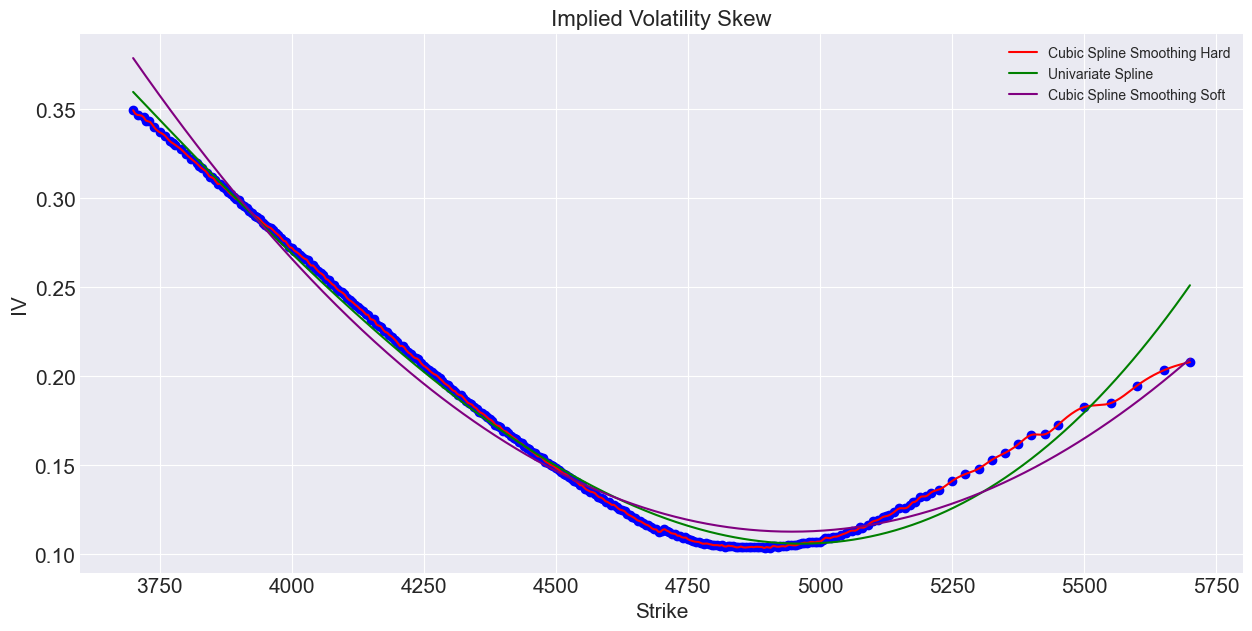

In [188]:
from scipy.interpolate import UnivariateSpline, CubicSpline

univ_spline = UnivariateSpline(iv_smile.index, iv_smile, s=1)  # s=1 for slight smoothing
cubic_spline_soft = UnivariateSpline(iv_smile.index, iv_smile, k = 2, s=2) 
cubic_spline_hard = CubicSpline(iv_smile.index, iv_smile)

strike_grid = np.linspace(iv_smile.index.min(), iv_smile.index.max(), 500)
iv_smooth_univ = univ_spline(strike_grid)
iv_smooth_cubic_soft = cubic_spline_soft(strike_grid)
iv_smooth_cubic_hard = cubic_spline_hard(strike_grid)


plt.figure(figsize=(15, 7))
plt.scatter(iv_smile.index, iv_smile, color='blue')

plt.plot(strike_grid, iv_smooth_cubic_hard, color='red', label="Cubic Spline Smoothing Hard")
plt.plot(strike_grid, iv_smooth_univ, color='green', label="Univariate Spline")
plt.plot(strike_grid, iv_smooth_cubic_soft, color='purple', label="Cubic Spline Smoothing Soft")

plt.xlabel('Strike', fontsize=15)
plt.ylabel('IV', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('Implied Volatility Skew', fontsize=16)
plt.legend()
plt.show()

Here we see the trade-off between overfitting—exemplified by the aggressive cubic spline—and underfitting when using a simplistic univariate spline. The optimal solution lies midway between these two extremes.

We can see that for the Hard cubic smoothign the **convexity** is not respected. For instance, one could enter a kalendar spread centered at K = 4750 and make a porift without risk (arbitrage) which violates the arbitrage-free surface.

## **Construct the IV surface**

In [8]:
def compute_iv_surface(options):
    surface_data = []

    for (date, expiry), group in options.groupby(["date", "expiry"]):
        smile = extract_iv_smile(group, date)
        for strike, iv in smile.items():
            surface_data.append({
                "date": date,
                "expiry": expiry,
                "dte": group['dte'].iloc[0],
                "strike": strike,
                "iv": iv
            })

    return pd.DataFrame(surface_data)

## **IV Surface Modelling**

In [70]:
from abc import ABC, abstractmethod

class IVSurfaceModel(ABC):
    """Abstract base for any IV‐surface model."""
    def __init__(self):
        # once you fit, we’ll remember the spot price
        self._spot: float = None
        
    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def _implied_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass

    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )

        # log‐moneyness
        df['k'] = np.log(df['strike'] / df['underlying_last'])
        # total variance
        df['w'] = df['iv_smile']**2 * df['T']

        return df

    def implied_vol(self, K: np.ndarray, T: np.ndarray) -> np.ndarray:
        K_arr = np.atleast_1d(K).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        if not hasattr(self, "_spot"):
            raise RuntimeError("You must .fit(...) first to set self._spot")

        k_arr = np.log(K_arr / self._spot)

        # compute total variance
        w = self._implied_variance(k_arr, T_arr)   # could be scalar, 1-D or 2-D

        if w.ndim == 2 and T_arr.ndim == 1:
            T_arr = T_arr[:, None]   # shape (nT,1) so w/T broadcasts to (nT,nK)

        iv = np.sqrt(w / T_arr)

        if iv.size == 1:
            return iv.item()
        return iv

    def greeks(self, k, T, S, dS, dSigma, dt):
        """Compute Δ, Γ, Θ, ν via analytic repricer if available."""
        raise NotImplementedError  # override if your model supports Greeks

    def check_arbitrage(self):
        """Run convexity & monotonicity diagnostics."""
        # e.g. finite‐diff ∂^2w/∂k^2 ≥ 0, ∂w/∂T ≥ 0
        pass

### **Non-parametric: Spline interpolation**


In [487]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class InterpSurface(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        self._last_market = market_data.copy()
        self._spot = market_data["underlying_last"].iloc[0]

        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy() # Total variance

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def _implied_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        if self._1d_spline is not None:
            # Only one maturity in fit → ignore T
            return self._1d_spline(k)
        
        # 2D interpolation via griddata
        ks, Ts, ws = self._2d_data
        pts = np.column_stack((ks, Ts))

        # 2) build a mesh of *query* k‐and‐T pairs
        Kq, Tq = np.meshgrid(k, T, indexing="xy")        # (len(T), len(k))
        qry = np.column_stack((Kq.ravel(), Tq.ravel())) # (len(T)*len(k), 2)

        # 3) interpolate and reshape back into (len(T), len(k))
        Wq = griddata(pts, ws, qry, method=self.method)
        return Wq.reshape(len(T), len(k))
    
    def plot_smile(
        self,
        T: float,
        moneyness_band: Tuple[float, float] = [0.8, 1.2],
        n: int = 200,
        show_market: bool = True,
        ax: plt.Axes = None
    ) -> plt.Axes:
        """Plot the fitted IV smile at maturity T."""
        df_market = self._last_market.copy()
        dtes = (df_market["T"] * 252).unique()
        target_dte = int(round(T * 252))
        closest = int(min(dtes, key=lambda d: abs(d - target_dte)))
        df_T = df_market[np.isclose(df_market["T"] * 252, closest)]

        strikes_obs = df_T["strike"]
        K_min, K_max = strikes_obs.min(), strikes_obs.max()

        if moneyness_band is not None:
            m_lo, m_hi = moneyness_band
            spot = df_market["underlying_last"].iloc[0]
            K_min = max(K_min, spot * m_lo)
            K_max = min(K_max, spot * m_hi)

        df_T = df_T[(df_T["strike"] >= K_min) & (df_T["strike"] <= K_max)]
        strikes = np.linspace(K_min, K_max, n)
        iv_model = self.implied_vol(strikes, T).squeeze()

        if ax is None:
            fig, ax = plt.subplots(figsize=(15, 7))
            
        ax.plot(strikes, iv_model, label=f"Model IV (DTE={closest}-day)", lw=2)

        # overplot market points if desired
        if show_market:
            df_T = self.prepare_iv_surface(df_T) # to get 'iv_smile'
            ax.scatter(
                df_T["strike"],
                df_T["iv_smile"],
                color="C1", s=30,
                label=f"Market IV (DTE={closest}-day)"
            )

        ax.set_title(f"Implied Vol Smile @ {closest}-day DTE", fontsize=14)
        ax.set_xlabel("Strike", fontsize=12)
        ax.set_ylabel("Implied Vol", fontsize=12)
        ax.legend()
        ax.grid(True)

        return ax

    def plot_surface(
        self,
        moneyness_band=(0.8, 1.2),
        dte_band=(1, 252),
        n_strikes=50,
        n_dtes=50,
        ax=None
    ):
        """
        Plot the full IV surface over strike and maturity.

        Parameters:
        - moneyness_band: (min_mult, max_mult) relative to spot
        - dte_band: (min_days, max_days)
        - n_strikes: # grid points in strike dimension
        - n_dtes: # grid points in DTE dimension
        - ax: optional matplotlib 3D Axes
        """
        df = self._last_market.copy()
        spot = df["underlying_last"].iloc[0]

        # filter maturities
        df['DTE'] = (df['T'] * 252).round().astype(int)
        valid = np.unique(df['DTE'])
        d_min, d_max = dte_band
        dtes = valid[(valid >= d_min) & (valid <= d_max)]
        if len(dtes)==0:
            raise ValueError("No expiries in dte_band")
        
        # build T grid in years
        T_grid = np.linspace(d_min/252, d_max/252, n_dtes)

        # determine strike band
        strikes_obs = df[df['DTE'].isin(dtes)]['strike']
        K_min = max(strikes_obs.min(), spot*moneyness_band[0])
        K_max = min(strikes_obs.max(), spot*moneyness_band[1])
        K_grid = np.linspace(K_min, K_max, n_strikes)

        # mesh and evaluate
        IV_mesh = self.implied_vol(K_grid, T_grid)
        K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

        if ax is None:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(
            K_mesh, T_mesh*252, IV_mesh,
            cmap='viridis', alpha=0.8, antialiased=True

        )

        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            ginfo = axis._axinfo["grid"]
            ginfo['color']     = (0.1, 0.1, 0.1, 0.2)
            ginfo['linewidth'] = 0.5
        
        ax.set_facecolor('white')
        ax.zaxis.labelpad = 10 
        ax.tick_params(axis='z', pad=6)
        ax.set_xlabel('Strike', fontsize=12)
        ax.set_ylabel('DTE (days)', fontsize=12)
        ax.set_zlabel('Implied Vol', fontsize=12)
        ax.set_title('Implied Volatility Surface', fontsize=16, y=1.03)
        
        cbar = plt.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)
        cbar.set_label('IV', rotation=0, labelpad=15)

        return ax

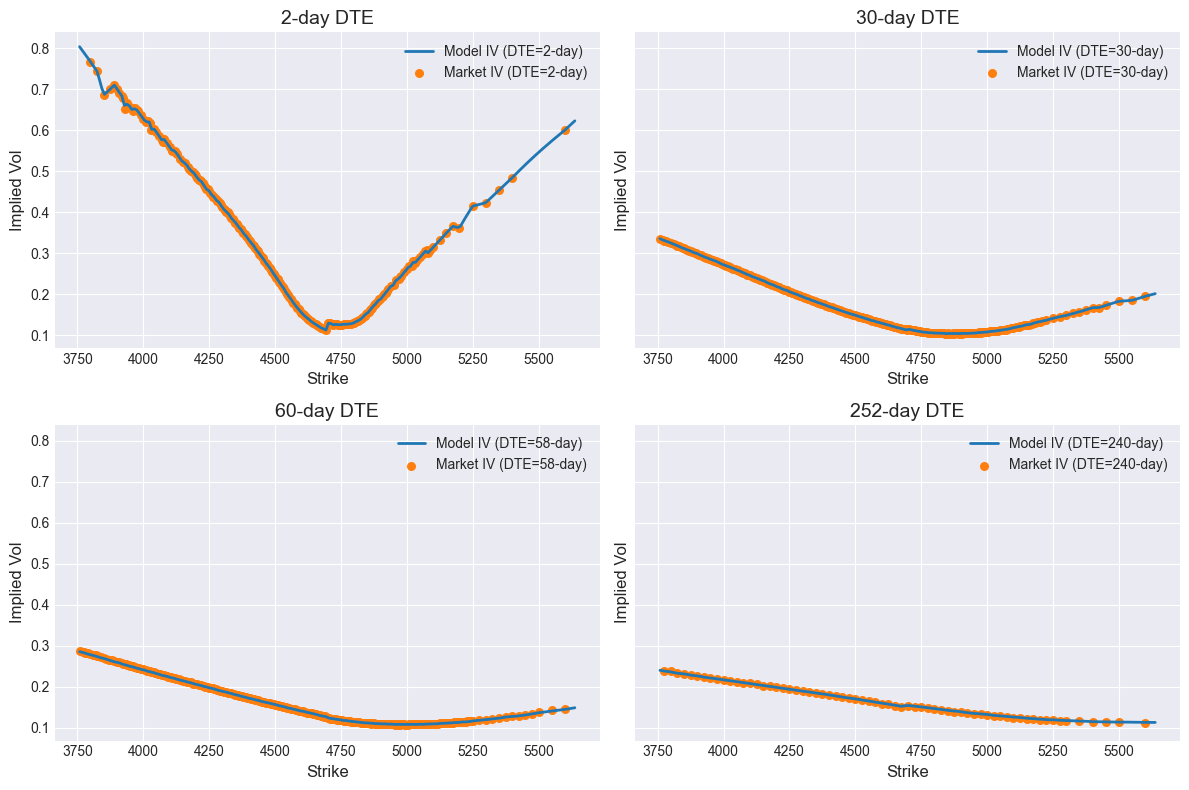

In [488]:
options_red = options[options.index == date]
iv_surf = InterpSurface(method='linear')
iv_surf.fit(options_red)

dtes = [2, 30, 60, 252]
ph.plot_smiles(iv_surf, dtes)

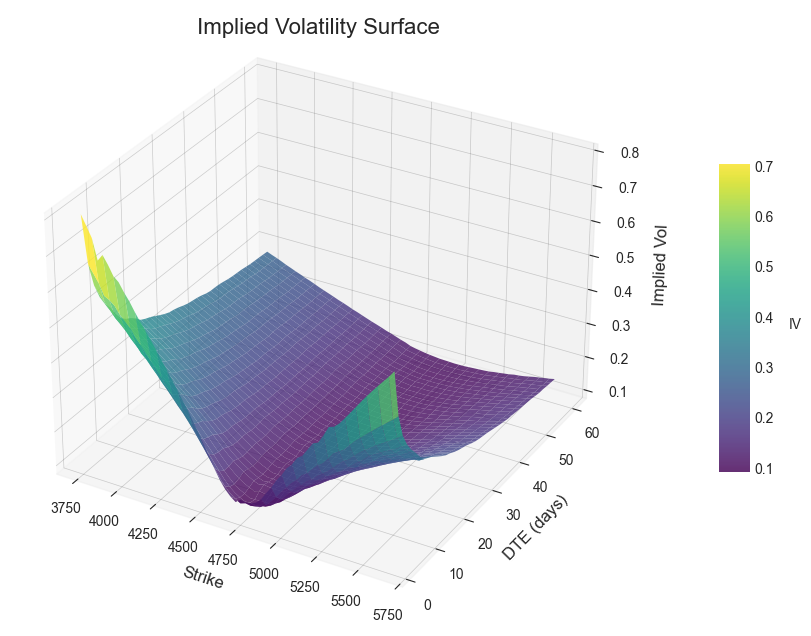

In [484]:
ax = iv_surf.plot_surface(
    moneyness_band=(0.8,1.2),
    dte_band=(2,60),
    n_strikes=60,
    n_dtes=40
)
plt.show()




### **Parametric: Stochastic Volatility Inspired (SVI)**
